In [1]:
source("L:/Duncan/eoepaper/functions.R")

Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.5.3"Loading required package: cowplot
Warning message:
"package 'cowplot' was built under R version 3.5.3"
********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************

Loading required package: Matrix
Warning message:
"package 'feather' was built under R version 3.5.3"Warning message:
"package 'dplyr' was built under R version 3.5.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: viridisLite
Warning message:
"package 'tidyr' was built under R version 3.5.3"
Attaching package: 'tidyr'

The following object

In [2]:
data = arrow::read_feather('wen_df.feather') %>% as.data.frame()

In [3]:
rownames(data) = data$index
id = which(colnames(data) == 'index')
data = data[,-id]
dim(data)
rownames(data)[1:10]
colnames(data)[1:10]

[1] 56322  1089

[1] "OLFM5P"        "RP11-344E13.1" "C2orf40"       "RP11-17M15.2" 
 [5] "LA16c-312E8.5" "RBP7"          "OR11H6"        "OR1F12"       
 [9] "PAN3"          "RNU6-466P"

[1] "Apr11_Cell_10"  "Apr11_Cell_101" "Apr11_Cell_112" "Apr11_Cell_123"
 [5] "Apr11_Cell_134" "Apr11_Cell_145" "Apr11_Cell_156" "Apr11_Cell_167"
 [9] "Apr11_Cell_178" "Apr11_Cell_189"

Scaling data matrix


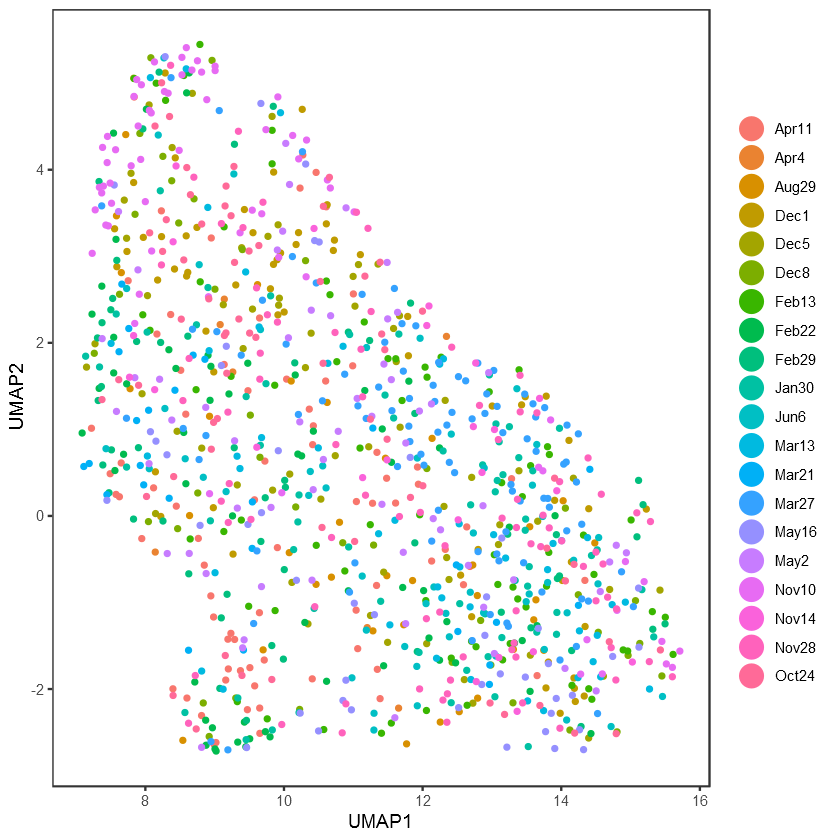

In [5]:
# process data through UMAP
seurat = CreateSeuratObject(data, min.cells = 3)
seurat = NormalizeData(seurat, scale.factor = 1000000)
seurat = FindVariableGenes(seurat, do.plot = FALSE, do.recalc = TRUE)
seurat = ScaleData(seurat)
seurat = RunPCA(seurat, genes.use = seurat@var.genes, do.print = FALSE)
seurat = RunUMAP(seurat, dims.use = 1:10)
DimPlot(seurat, 'umap')

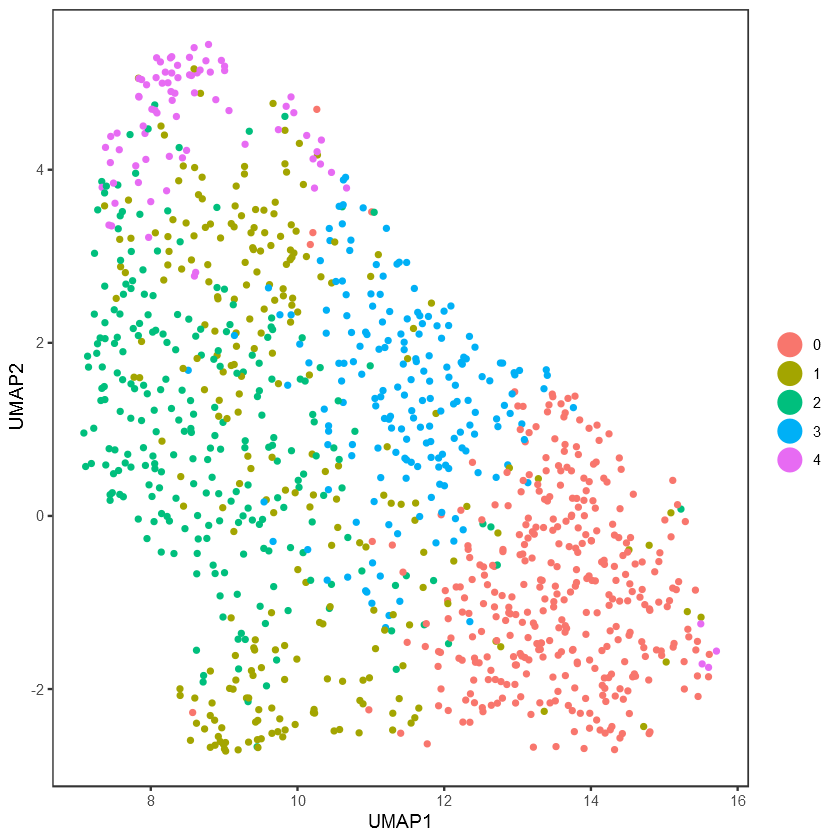

In [7]:
seurat = FindClusters(seurat, resolution = .8, dims.use = 1:10, print.output = FALSE)
DimPlot(seurat, 'umap')

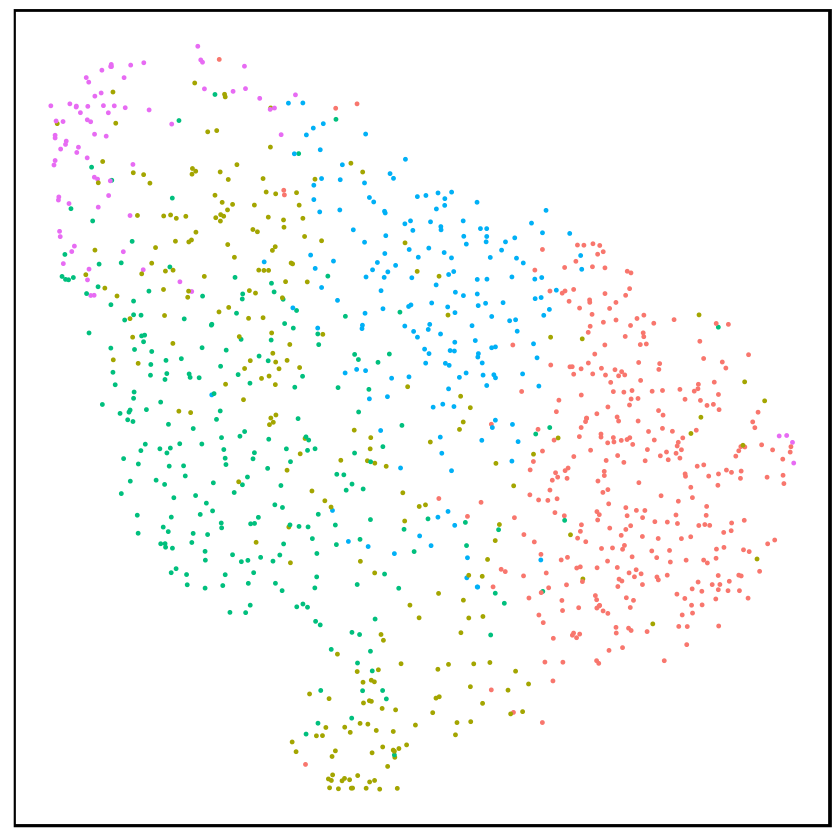

In [23]:
ggplot(seurat@meta.data, aes(x = UMAP1, y = UMAP2, color = res.0.8)) + geom_point(size = .3) + UMAP_theme 
ggsave('L:/Duncan/eoepaper/LiteratureComparisons/wen_umap.pdf', height = 2, width =2 , useDingbats = FALSE)

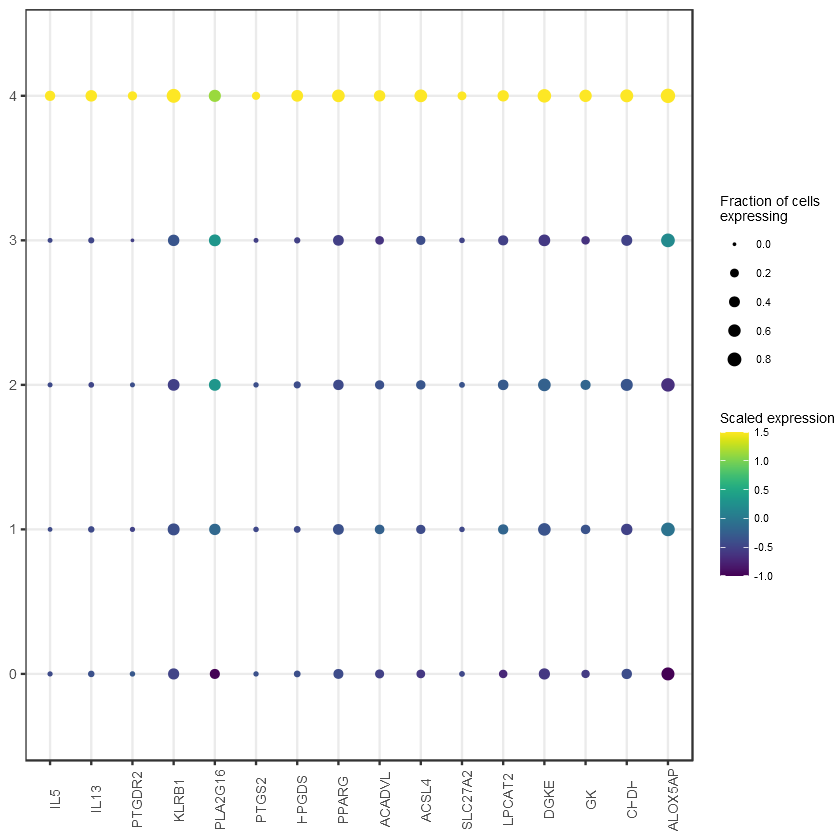

In [8]:
genes = c('IL5', 'IL13', 'PTGDR2', 'KLRB1', 'PLA2G16', 'PTGS2',  'HPGDS','PPARG','ACADVL', 'ACSL4','SLC27A2', 'LPCAT2','DGKE', 'GK','CHDH', 'ALOX5AP')
# Panel 3: phenotype of eosinophils and neutrophils
pct = function(x) {
  sum(x >0)/length(x)
}
meanexp = function(x) {
    mean(x)
}

data = as.data.frame(t(as.matrix(seurat@data[genes,])))
data$phenotype = seurat@meta.data$res.0.8
df_exp = data %>% group_by(phenotype) %>% summarize_all(.funs = list(meanexp)) %>% as.data.frame() 
keep = df_exp
df_exp[,2:(1+length(genes))] = scale(df_exp[,2:(1+length(genes))])
df_exp = df_exp %>% melt(id.vars = 'phenotype')
df_pct = data %>% group_by(phenotype) %>% summarize_all(.funs = list(pct)) %>% melt(id.vars = 'phenotype')
df_exp$value[df_exp$value > 1.5] = 1.5
df_exp$value[df_exp$value < -1]= -1
df_exp$pct = df_pct$value
df_exp$value = as.vector(df_exp$value)
#df_exp$value[is.nan(df_exp$value)] = 0

ggplot(as.data.frame(df_exp), aes(y = phenotype, x = variable, size = pct, color = value)) + geom_point() + scale_color_viridis()  + 

 theme_bw()  + theme(axis.title = element_blank(), axis.text.x = element_text(angle = 90)) + 
labs(color = "Scaled expression", size = 'Fraction of cells\nexpressing') + scale_x_discrete(limits = genes) + Axis_themes + 
theme(axis.title = element_blank(), axis.text.x = element_text(size = 8), axis.text.y = element_text(size = 8))+ 
 scale_size_continuous(range = c(0, 3))
ggsave('L:/Duncan/eoepaper/LiteratureComparisons/wen_dots.pdf', height = 2, width = 3.5, useDingbats = FALSE)